JJJ

In [1]:
#Settings relative to .ipynb file format that have to be executed here

#Make reloading of modules automatic et évite d'avoir à redémarer le kernel et tout re executer pour appliquer la modification d'un module dans __main__.
%load_ext autoreload  
%autoreload 2

In [2]:
#src.useful_functions
import sys
sys.path.append('../src')  # Adjust the path to import modules in src/



from data import make_dataset
from data import preprocessing
from visualization import visualize
import user_test
from pipeline import model, results
from sklearn.base import clone

Beginning of the test

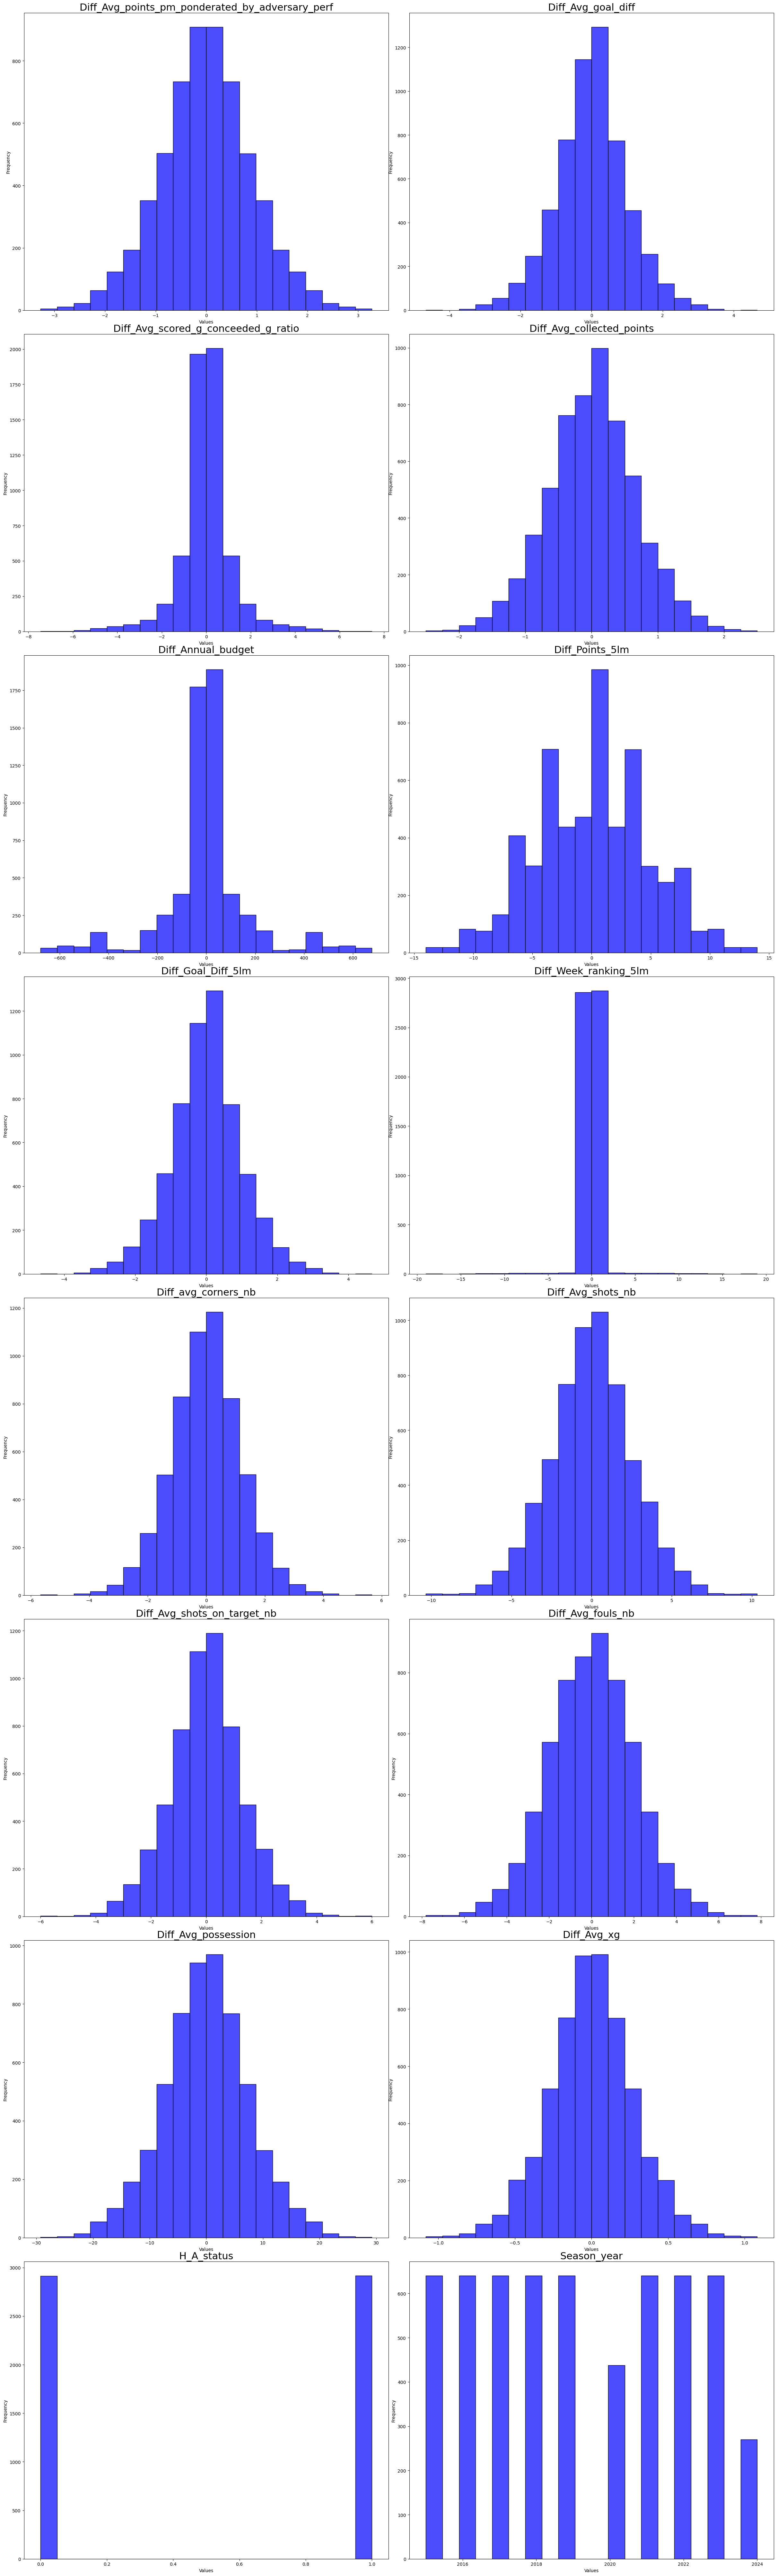

In [3]:
#Importation of the fotball data
X   = make_dataset.load_data(False, 'processed/not_split/X')
Y   = make_dataset.load_data(False, 'processed/not_split/Y')
X_info = make_dataset.load_data(False, 'processed/not_split/X_info')


# Short data insight
visualize.plot_all_num_features(X, save = False, density_estimate = False)

- All the features names starts with 'Diff_' as they all are the difference of a given statistic for the two teams which confront.

- The features presented above are the ones kept after a selection among more than 150


We start splitting the dataset with 6 seasons in trainset and 3 in test set.

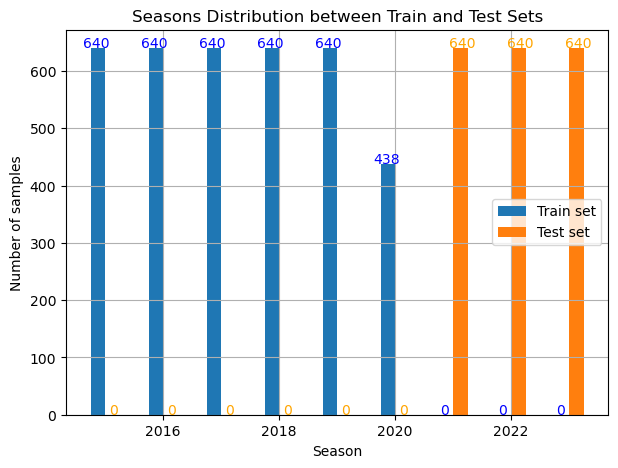

In [4]:
#Load the train and test datasets:
X_train_00   = make_dataset.load_data(False, 'processed/split/X_train_00')
Y_train_00   = make_dataset.load_data(False, 'processed/split/Y_train_00')
X_test_00   = make_dataset.load_data(False, 'processed/split/X_test_00')
Y_test_00   = make_dataset.load_data(False, 'processed/split/Y_test_00')

# Show dataset train and test sets repratition
preprocessing.hist_seasons(X_train_00.copy(), X_test_00.copy())

The shorter bar in 2020 is the covid season which was interupted before the end. We decided not to shuffle samples as in a realistic case we train our model before the begining of the season. We will see below a more sophisticated strategy of training based on weekly or annual model training

<span style="color:#FF8000;"> <strong> <font size="4"> Model definition

In [20]:

# Chose a number of features the selector will select

nb_of_feat_to_select = 15


### Chose Scaler

# RobustScaler 
# StandardScaler
# MinMaxScaler

Scaler = "StandardScaler"


### Chose Logistic Rgression regularization penalty

# l1
# l2
# elasticnet
# None

penalty = 'l2'


### Chose regularization factor

C = 10


# Create the pipeline
personalised_pipeline = user_test.create_pipeline(nb_of_feat_to_select, Scaler, penalty, C)

# Model training
personalised_pipeline.fit(X_train_00.copy(), Y_train_00.copy().values.ravel())


# Just to have an idea of the optimal parameters combination
# Best pipeline developed by myself
best_pipeline = model.load_pipeline("chosen_pipeline")
print(best_pipeline)

Successfully loaded the pipeline: chosen_pipeline


Pipeline(steps=[('scaler', StandardScaler()),
                ('features_selector', SelectKBest(k=13)),
                ('model',
                 LogisticRegression(C=0.025118864315095808, max_iter=3000,
                                    multi_class='auto', random_state=999,
                                    solver='newton-cg', verbose=False))])


c:\Users\polol\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\polol\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SelectKBest from version 1.3.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\polol\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.5.1. This might lead to breakin

Perform pipeline prediction on test set

In [21]:
#Make 'normal' proba predictions 
normal_proba_pred = personalised_pipeline.predict_proba(X_test_00)[:,1]

#Make proba predictions retraining the pipeline at every Game Week or every Season:
proba_pred_GW_training, Y_test_GW_training, X_info_GW_training = results.proba_prediction_retrained_each_seas(X, Y, X_info, clone(personalised_pipeline), 'season', test_seasons =[2021,2022,2023])


c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\notebooks\../src\pipeline\results.py:495: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_info_pred = pd.concat([X_info_pred, X_test_info_for_this_seas], ignore_index=True, axis=0)


We first perform a classic prediction based on the previously trained pipeline. Below we perform the "sophisticated" method train-test split. We retrain the pipeline at every season before performing prediction for the coming season. The choice of an annual retrraining and not a weekly has been made after tests which shows that this was the best option.

Pipeline log-loss score

In [41]:

# Normally trained pipeline log-loss
user_test.pipe_log_loss(Y_test_00, normal_proba_pred, GW_training= False)
# Annualy trained pipeline log-loss
user_test.pipe_log_loss(Y_test_GW_training.values.ravel(), proba_pred_GW_training, GW_training= True)

#Best pipeline build los-loss
user_test.best_pipe_log_loss()

Your personnalised pipeline log-loss is:                   0.6129401634209446
Your personnalised pipeline log-loss, annualy trained, is: 0.6025199296354605
The best pipeline log-loss is:                             0.5971624853556956


Plot pipeline performances

Successfully loaded the datasets: pipeline_pred_proba_and_Y_and_X_info


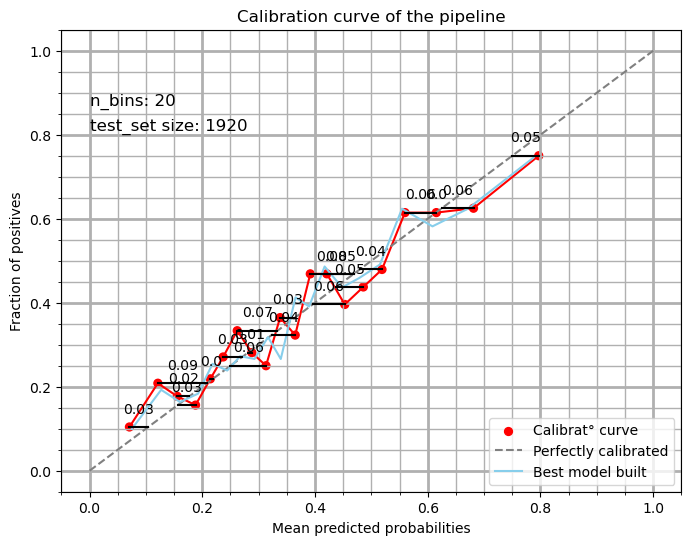

Above learning curve statistics on bins:

╒════╤════════════════╤═════════════════════════════╕
│    │ Bin interval   │   Predictions nb in the bin │
╞════╪════════════════╪═════════════════════════════╡
│  0 │ [0.02, 0.1]    │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  1 │ [0.1, 0.14]    │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  2 │ [0.14, 0.17]   │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  3 │ [0.17, 0.2]    │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  4 │ [0.2, 0.23]    │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  5 │ [0.23, 0.25]   │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  6 │ [0.25, 0.27]   │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  7 │ [0.27, 0.3]    │                 

In [43]:


# We choose wether we plot the graphs on annual training simulations or on 'normal' training simulations

plot_with_annual_training = True


user_test.plot_pipeline_pred_results(proba_pred_GW_training, Y_test_GW_training, X_info_GW_training, normal_proba_pred, Y_test_00, X_test_00, plot_with_annual_training, best_model_plot=True)



The first table above contains the number of samples per bin and the probabilities interval of each bin. The second table contains, for each bin, the difference between the average of true probabilities in the bin and the average of predicted probability of the bin.

Considering the better results with the annual training method we abandon tests on 'normal' training and continue only with the annually retrained pipeline predictions

Comparaison of predicted probabilities and bookmakers proba

In [64]:
# Compare personalised pipeline predicted proba and odds proba for annual retraining
odd_proba_pred_proba_compa_dataset = results.compare_pred_proba_and_odds(proba_pred_GW_training.copy() ,X_info_GW_training.copy())

display(odd_proba_pred_proba_compa_dataset)

results.compare_pred_proba_and_odds_stats(odd_proba_pred_proba_compa_dataset)

c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\notebooks\../src\pipeline\results.py:651: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  )


,Team_we_pred_vict_proba,Adversary,Game Week,Date,Played_matchs_nb,Max_victory_odd,Avg_victory_odd,Proba pred,Diff proba_pred avg_odd proba,Diff proba_pred Max_odd proba
0,Dijon,Rennes,7,2020-10-16 17:00:00,6,5.280000,5.020000,10.1%,-9.8%,-8.8%
1,Nîmes,PSG,7,2020-10-16 19:00:00,6,8.300000,7.190000,11.7%,-2.2%,-0.3%
2,Reims,Lorient,7,2020-10-17 15:00:00,6,2.200000,2.110000,36.9%,-10.5%,-8.5%
3,Marseille,Bordeaux,7,2020-10-17 19:00:00,6,2.130000,2.030000,48.8%,-0.5%,1.8%
4,Strasbourg,Lyon,7,2020-10-18 11:00:00,6,3.700000,3.460000,9.4%,-19.5%,-17.7%
5,Angers,Metz,7,2020-10-18 13:00:00,6,2.180000,2.040000,36.5%,-12.5%,-9.3%
6,Monaco,Montpellier,7,2020-10-18 13:00:00,6,1.540000,1.500000,55.0%,-11.7%,-10.0%
7,Nantes,Brest,7,2020-10-18 13:00:00,6,2.220000,2.140000,36.6%,-10.2%,-8.5%
8,St Etienne,Nice,7,2020-10-18 15:00:00,6,2.430000,2.340000,35.6%,-7.2%,-5.6%
9,Lille,Lens,7,2020-10-18 19:00:00,6,1.970000,1.870000,40.3%,-13.2%,-10.5%


,Mean Absolute Difference,25th Percentile,Median,75th Percentile
Diff proba_pred avg_odd proba,0.050538,0.018,0.04,0.07
